In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
import xml.etree.ElementTree as ET
import os

In [12]:
def parse_bbox(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    bounding_box = root.find('.//bndbox')
    x_min = int(bounding_box.find('xmin').text)
    y_min = int(bounding_box.find('ymin').text)
    x_max = int(bounding_box.find('xmax').text)
    y_max = int(bounding_box.find('ymax').text)

    return (x_min, y_min, x_max, y_max)


In [13]:
def load_dog_images(*directories):
    image_list = []
    label_list = []
    for class_idx, directory in enumerate(directories):
        temp_images = []
        directory = directory.replace("\\", "/")
        breed_name = directory.split("/")[-1]
        annotation_dir = os.path.join('/content/drive/MyDrive/dogs_dataset/Annotation', breed_name)
        print(f"Loading images from directory: {directory}")
        print(f"Annotation directory: {annotation_dir}")

        for img_file, ann_file in zip(os.listdir(directory), os.listdir(annotation_dir)):
            img_path = os.path.join(directory, img_file)
            ann_path = os.path.join('/content/drive/MyDrive/dogs_dataset/Annotation', breed_name, ann_file)

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            xmin, ymin, xmax, ymax = parse_bbox(ann_path)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_cropped = img[ymin:ymax, xmin:xmax]

            if img_cropped.size == 0:
                continue

            img_resized = cv2.resize(img_cropped, (250, 250))
            temp_images.append(img_resized)

        labels = np.full(len(temp_images), class_idx)
        image_list.extend(temp_images)
        label_list.extend(labels)

    return np.array(image_list), np.array(label_list), len(set(label_list))

images, labels, num_classes = load_dog_images(r"/content/drive/MyDrive/dogs_dataset/n02085936-Maltese_dog",
                                              r"/content/drive/MyDrive/dogs_dataset/n02086240-Shih-Tzu",
                                              r"/content/drive/MyDrive/dogs_dataset/n02088094-Afghan_hound",
                                              r"/content/drive/MyDrive/dogs_dataset/n02106662-German_shepherd",
                                              r"/content/drive/MyDrive/dogs_dataset/n02109961-Eskimo_dog",
                                              r"/content/drive/MyDrive/dogs_dataset/n02110185-Siberian_husky",
                                              r"/content/drive/MyDrive/dogs_dataset/n02110958-pug",
                                              r"/content/drive/MyDrive/dogs_dataset/n02112018-Pomeranian",
                                              r"/content/drive/MyDrive/dogs_dataset/n02112137-chow",
                                              r"/content/drive/MyDrive/dogs_dataset/n02113023-Pembroke")


Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02085936-Maltese_dog
Annotation directory: /content/drive/MyDrive/dogs_dataset/Annotation/n02085936-Maltese_dog
Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02086240-Shih-Tzu
Annotation directory: /content/drive/MyDrive/dogs_dataset/Annotation/n02086240-Shih-Tzu
Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02088094-Afghan_hound
Annotation directory: /content/drive/MyDrive/dogs_dataset/Annotation/n02088094-Afghan_hound
Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02106662-German_shepherd
Annotation directory: /content/drive/MyDrive/dogs_dataset/Annotation/n02106662-German_shepherd
Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02109961-Eskimo_dog
Annotation directory: /content/drive/MyDrive/dogs_dataset/Annotation/n02109961-Eskimo_dog
Loading images from directory: /content/drive/MyDrive/dogs_dataset/n02110185-Siberian_husky
Annota

In [15]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(250, 250, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(renorm=True),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

breed_names = ['Maltese dog', 'Shih-Tzu', 'Afghan_hound', 'German shepherd', 'Eskimo_dog', 'Siberian_husky', 'Pug', 'Pomeranian', 'Chow', 'Pembroke']


Epoch 1/10
31/31 [==============================] - 149s 5s/step - loss: 1.5900 - accuracy: 0.4423
Epoch 2/10
31/31 [==============================] - 138s 4s/step - loss: 0.7210 - accuracy: 0.7559
Epoch 3/10
31/31 [==============================] - 141s 5s/step - loss: 0.5066 - accuracy: 0.8090
Epoch 4/10
31/31 [==============================] - 138s 4s/step - loss: 0.3627 - accuracy: 0.8560
Epoch 5/10
31/31 [==============================] - 137s 4s/step - loss: 0.3039 - accuracy: 0.8805
Epoch 6/10
31/31 [==============================] - 140s 4s/step - loss: 0.2190 - accuracy: 0.9173
Epoch 7/10
31/31 [==============================] - 138s 4s/step - loss: 0.2194 - accuracy: 0.9152
Epoch 8/10
31/31 [==============================] - 140s 5s/step - loss: 0.1865 - accuracy: 0.9305
Epoch 9/10
31/31 [==============================] - 137s 4s/step - loss: 0.1704 - accuracy: 0.9336
Epoch 10/10
8/8 [==============================] - 36s 4s/step - loss: 0.6511 - accuracy: 0.8449
Test Loss: 0

1/1 [==============================] - 2s 2s/step


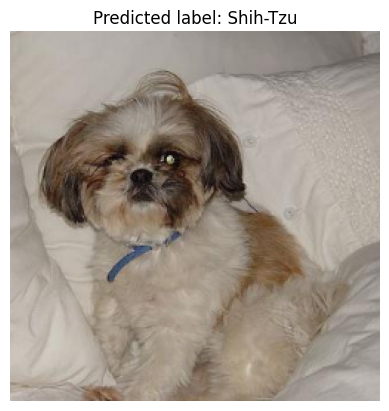

1/1 [==============================] - 0s 263ms/step


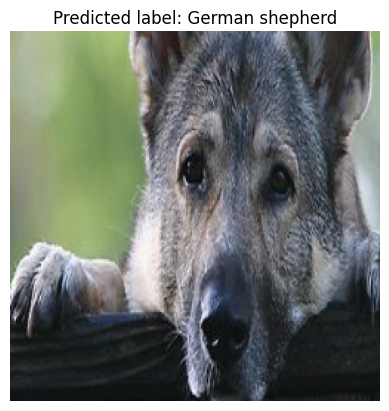

1/1 [==============================] - 0s 299ms/step


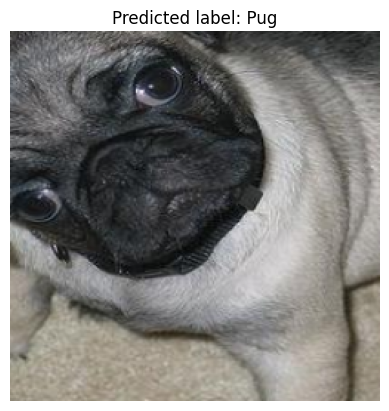

1/1 [==============================] - 0s 280ms/step


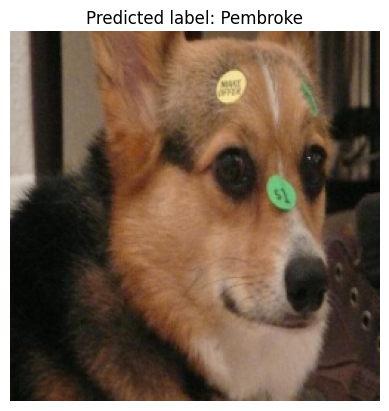

In [11]:
def predict_breed(index):
    predicted_prob = model.predict(X_test[[index]])
    predicted_label_index = np.argmax(predicted_prob)
    predicted_label = breed_names[predicted_label_index]
    plt.figure()
    plt.imshow(X_test[index])
    plt.title('Predicted label: ' + predicted_label)
    plt.axis("off")
    plt.show()

predict_breed(1)
predict_breed(11)
predict_breed(45)
predict_breed(101)